In [1]:
WORKSPACE_PATH = 'Tensorflow/workspace'
SCRIPTS_PATH = 'Tensorflow/scripts'
APIMODEL_PATH = 'Tensorflow/models'
ANNOTATION_PATH = WORKSPACE_PATH+'/annotations'
IMAGE_PATH = WORKSPACE_PATH+'/images'
MODEL_PATH = WORKSPACE_PATH+'/models'
PRETRAINED_MODEL_PATH = WORKSPACE_PATH+'/pre-trained-models'
CONFIG_PATH = MODEL_PATH+'/my_ssd_mobnet/pipeline.config'
CHECKPOINT_PATH = MODEL_PATH+'/my_ssd_mobnet/'


In [2]:
labels = [{'name':'a', 'id':1},
         {'name':'b', 'id':2},
         {'name':'c', 'id':3},
         {'name':'d', 'id':4},
         {'name':'e', 'id':5},
         {'name':'f', 'id':6},
         {'name':'g', 'id':7},
         {'name':'h', 'id':8},
         {'name':'i', 'id':9},
         {'name':'j', 'id':10},
         {'name':'k', 'id':11},
         {'name':'l', 'id':12},
         {'name':'m', 'id':13},
         {'name':'n', 'id':14},
         {'name':'o', 'id':15},
         {'name':'p', 'id':16},
         {'name':'q', 'id':17},
         {'name':'r', 'id':18},
         {'name':'s', 'id':19},
         {'name':'t', 'id':20},
         {'name':'u', 'id':21},
         {'name':'v', 'id':22},
         {'name':'w', 'id':23},
         {'name':'x', 'id':24},
         {'name':'y', 'id':25},
         {'name':'z', 'id':26},
         ]

with open(ANNOTATION_PATH + '\label_map.pbtxt', 'w') as f:
    for label in labels:
        f.write('item { \n')
        f.write('\tname:\'{}\'\n'.format(label['name']))
        f.write('\tid:{}\n'.format(label['id']))
        f.write('}\n')

In [3]:
!python {SCRIPTS_PATH + '/generate_tfrecord.py'} -x {IMAGE_PATH + '/train'} -l {ANNOTATION_PATH + '/label_map.pbtxt'} -o {ANNOTATION_PATH + '/train.record'}
!python {SCRIPTS_PATH + '/generate_tfrecord.py'} -x{IMAGE_PATH + '/test'} -l {ANNOTATION_PATH + '/label_map.pbtxt'} -o {ANNOTATION_PATH + '/test.record'}

Successfully created the TFRecord file: Tensorflow/workspace/annotations/train.record
Successfully created the TFRecord file: Tensorflow/workspace/annotations/test.record


In [3]:
CUSTOM_MODEL_NAME = 'my_ssd_mobnet' 

In [4]:
import tensorflow as tf
from object_detection.utils import config_util
from object_detection.protos import pipeline_pb2
from google.protobuf import text_format


In [5]:
CONFIG_PATH = MODEL_PATH+'/'+CUSTOM_MODEL_NAME+'/pipeline.config'

In [6]:
CONFIG_PATH

'Tensorflow/workspace/models/my_ssd_mobnet/pipeline.config'

In [7]:
config = config_util.get_configs_from_pipeline_file(CONFIG_PATH)

In [8]:
pipeline_config = pipeline_pb2.TrainEvalPipelineConfig()
with tf.io.gfile.GFile(CONFIG_PATH, "r") as f:                                                                                                                                                                                                                     
    proto_str = f.read()                                                                                                                                                                                                                                          
    text_format.Merge(proto_str, pipeline_config)  

In [9]:
pipeline_config.model.ssd.num_classes = 26
pipeline_config.train_config.batch_size = 4
pipeline_config.train_config.fine_tune_checkpoint = PRETRAINED_MODEL_PATH+'/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint/ckpt-0'
pipeline_config.train_config.fine_tune_checkpoint_type = "detection"
pipeline_config.train_input_reader.label_map_path= ANNOTATION_PATH + '/label_map.pbtxt'
pipeline_config.train_input_reader.tf_record_input_reader.input_path[:] = [ANNOTATION_PATH + '/train.record']
pipeline_config.eval_input_reader[0].label_map_path = ANNOTATION_PATH + '/label_map.pbtxt'
pipeline_config.eval_input_reader[0].tf_record_input_reader.input_path[:] = [ANNOTATION_PATH + '/test.record']

In [10]:
config_text = text_format.MessageToString(pipeline_config)                                                                                                                                                                                                        
with tf.io.gfile.GFile(CONFIG_PATH, "wb") as f:                                                                                                                                                                                                                     
    f.write(config_text)   

TRAIN MODEL

In [11]:
print("""python {}/research/object_detection/model_main_tf2.py --model_dir={}/{} --pipeline_config_path={}/{}/pipeline.config --num_train_steps=40000""".format(APIMODEL_PATH, MODEL_PATH,CUSTOM_MODEL_NAME,MODEL_PATH,CUSTOM_MODEL_NAME))

python Tensorflow/models/research/object_detection/model_main_tf2.py --model_dir=Tensorflow/workspace/models/my_ssd_mobnet --pipeline_config_path=Tensorflow/workspace/models/my_ssd_mobnet/pipeline.config --num_train_steps=40000


In [12]:
# mAP 
print("""python {}/research/object_detection/model_main_tf2.py --model_dir={}/{} --pipeline_config_path={}/{}/pipeline.config --checkpoint_dir={}/{}""".format(APIMODEL_PATH,MODEL_PATH,CUSTOM_MODEL_NAME,MODEL_PATH,CUSTOM_MODEL_NAME,MODEL_PATH,CUSTOM_MODEL_NAME))

python Tensorflow/models/research/object_detection/model_main_tf2.py --model_dir=Tensorflow/workspace/models/my_ssd_mobnet --pipeline_config_path=Tensorflow/workspace/models/my_ssd_mobnet/pipeline.config --checkpoint_dir=Tensorflow/workspace/models/my_ssd_mobnet


In [12]:
import os
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder

In [13]:
# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(CONFIG_PATH)
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(CHECKPOINT_PATH, 'ckpt-41')).expect_partial()

@tf.function
def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

In [14]:
import cv2 
import numpy as np

In [15]:
category_index = label_map_util.create_category_index_from_labelmap(ANNOTATION_PATH+'/label_map.pbtxt')

In [27]:
IMAGE_PATH = 'Tensorflow/workspace/images/test/a (1).jpg'

In [16]:
import cv2 
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [17]:
# Setup capture
cap = cv2.VideoCapture(0)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

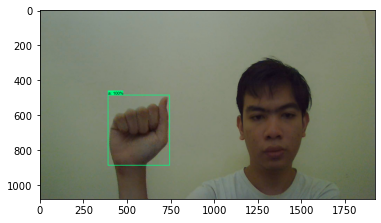

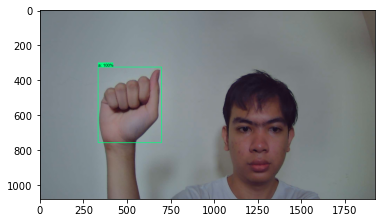

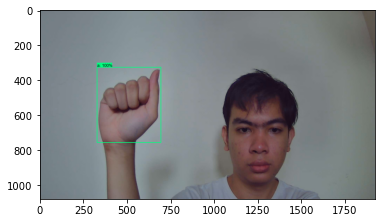

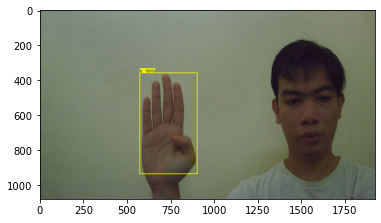

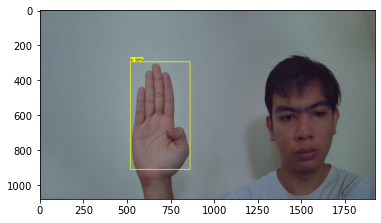

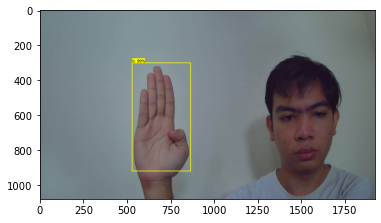

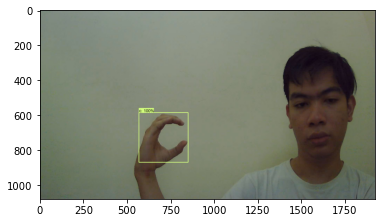

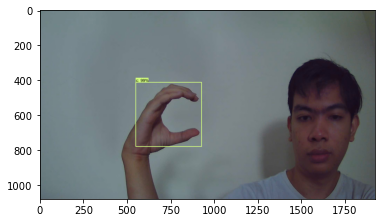

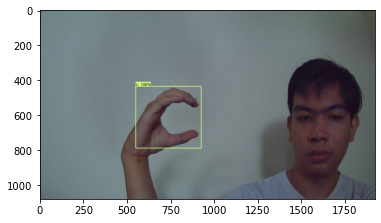

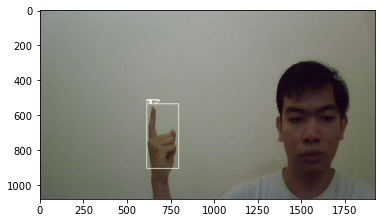

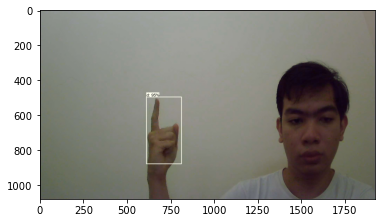

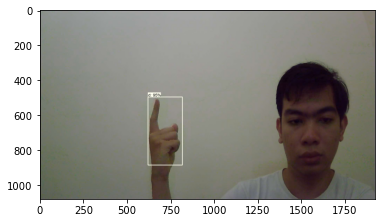

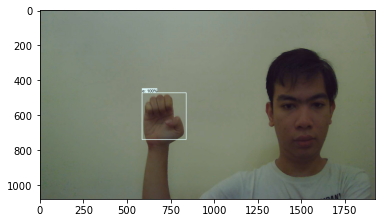

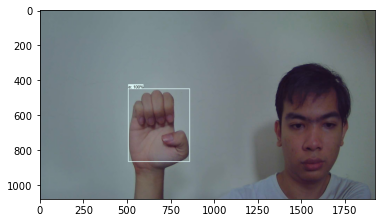

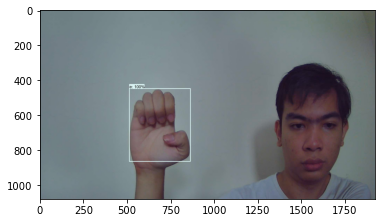

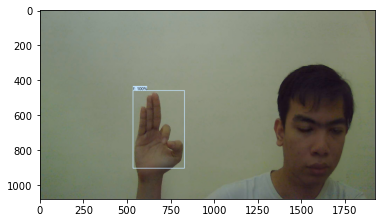

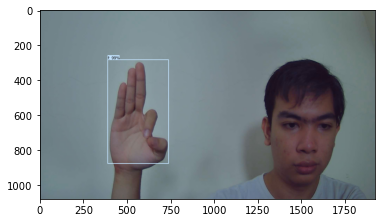

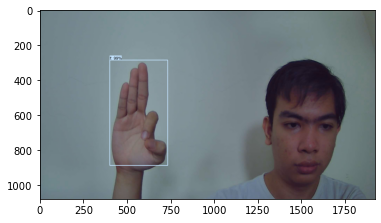

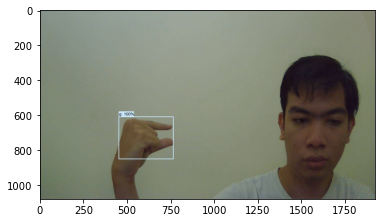

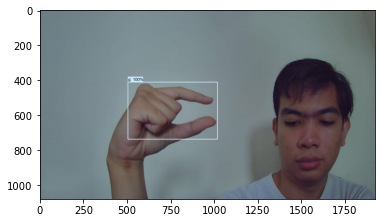

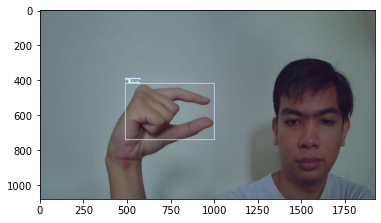

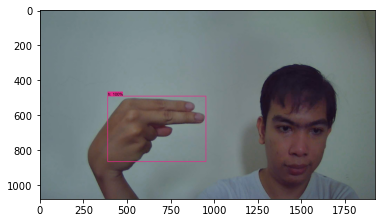

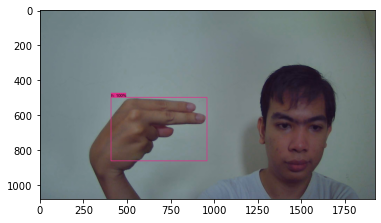

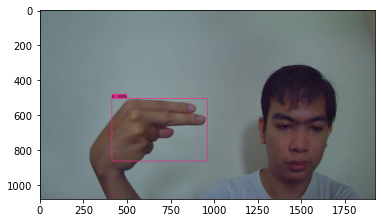

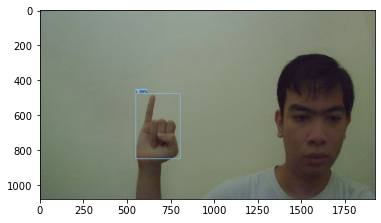

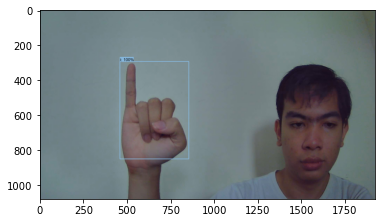

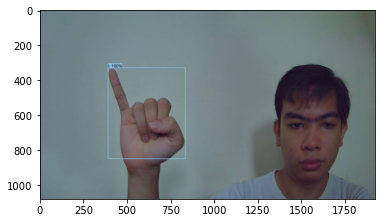

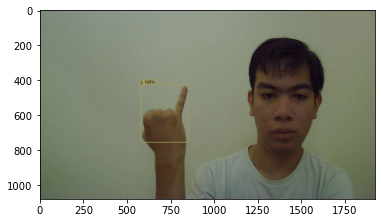

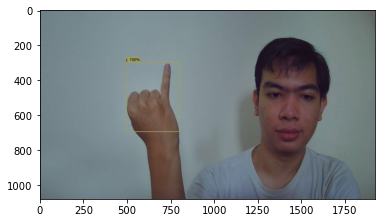

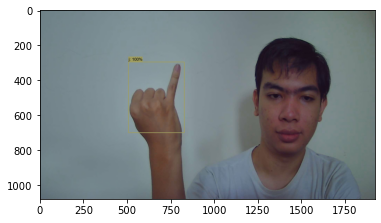

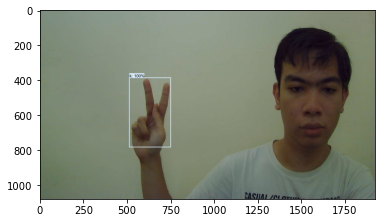

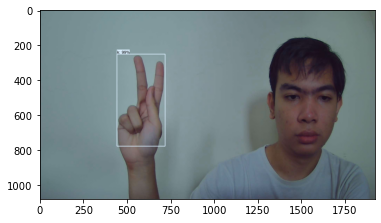

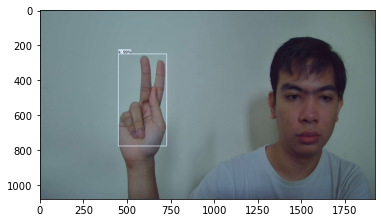

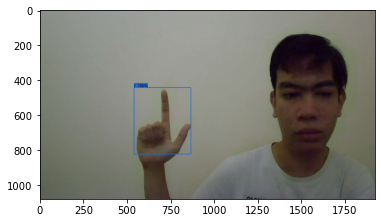

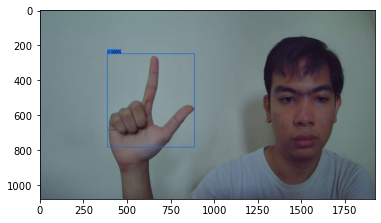

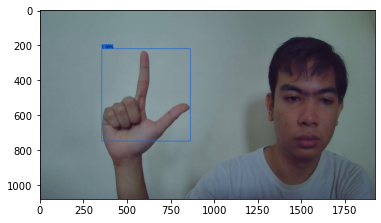

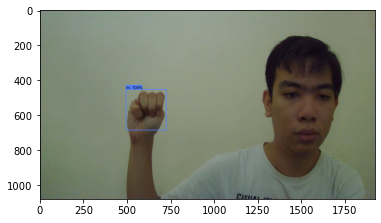

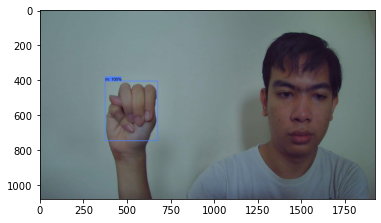

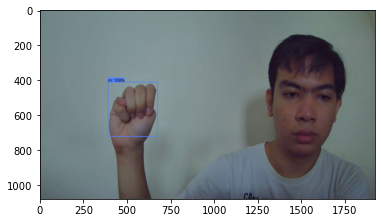

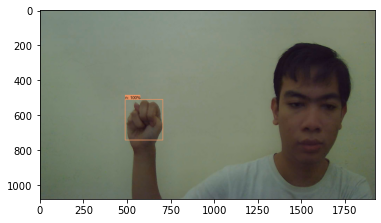

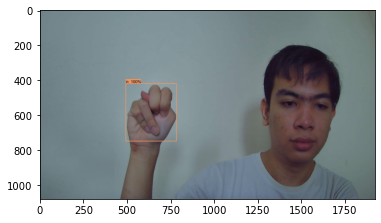

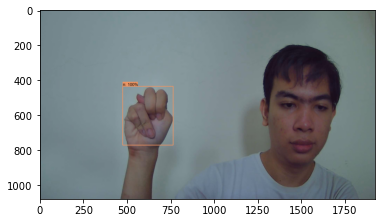

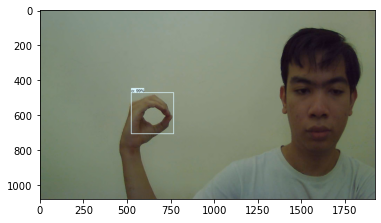

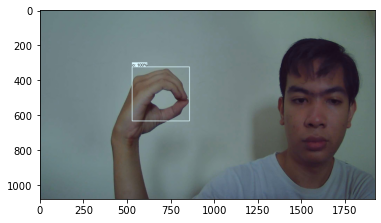

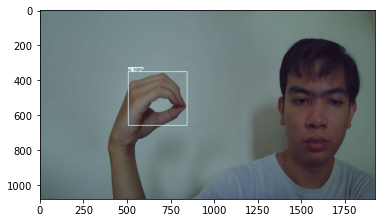

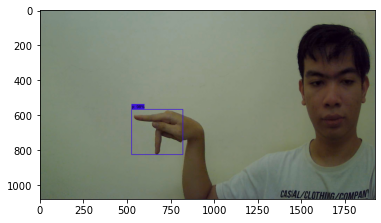

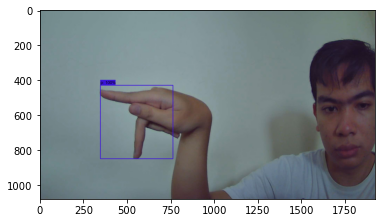

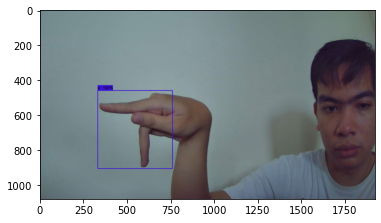

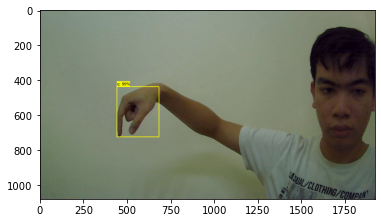

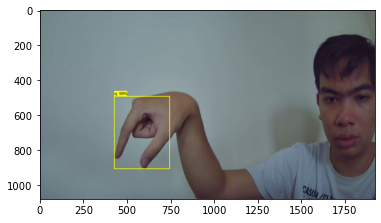

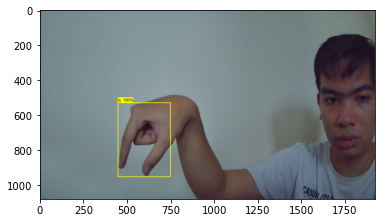

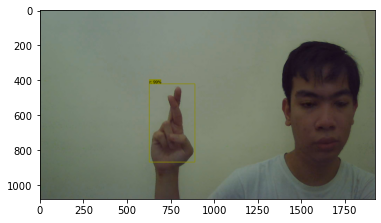

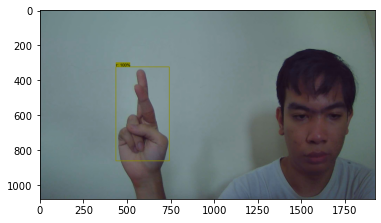

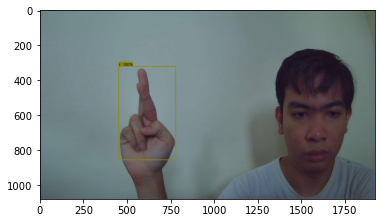

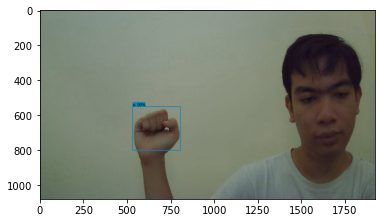

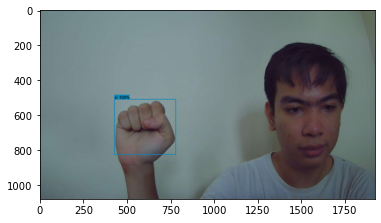

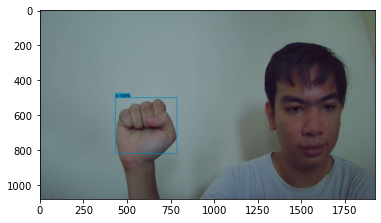

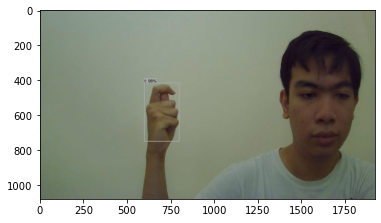

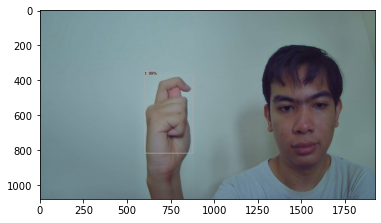

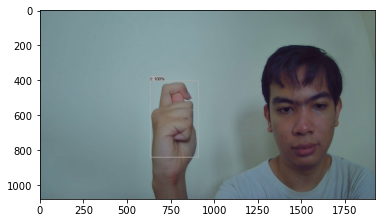

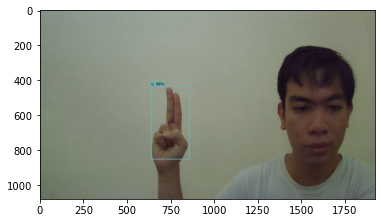

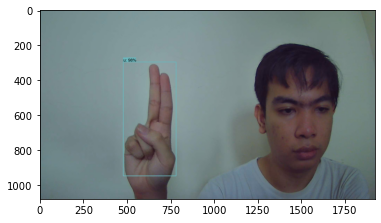

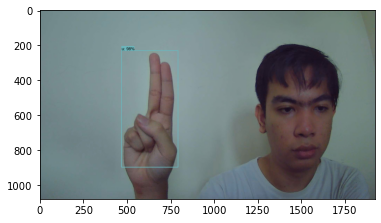

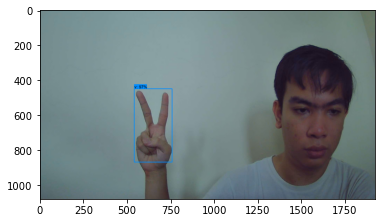

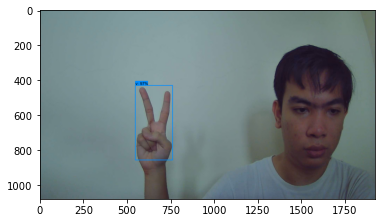

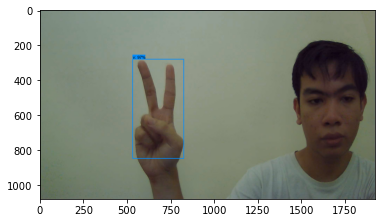

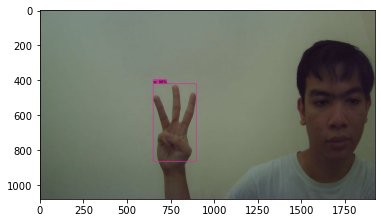

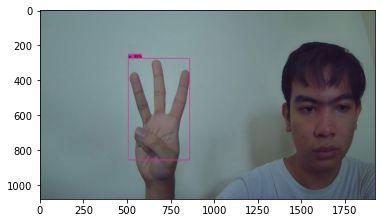

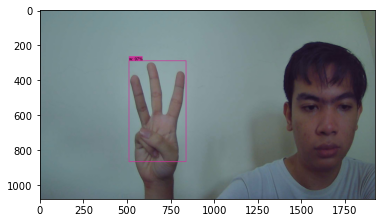

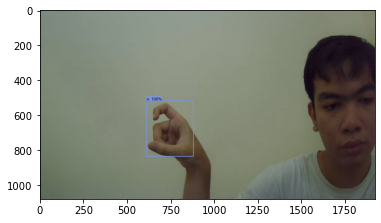

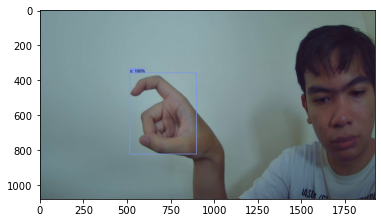

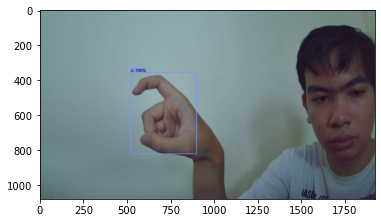

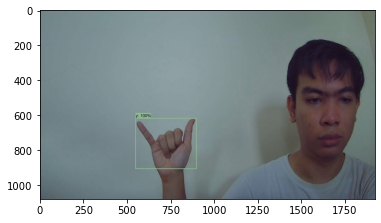

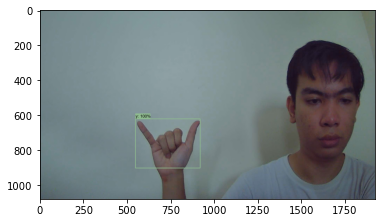

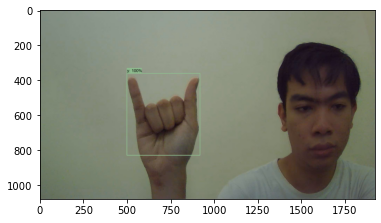

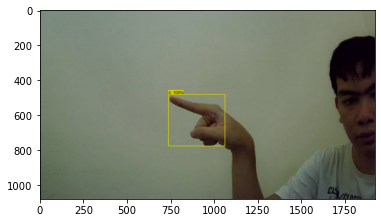

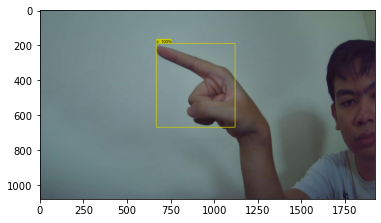

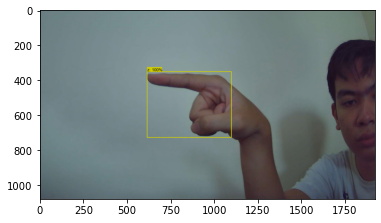

In [18]:
IMAGE_PATH = [
    "Tensorflow/workspace/images/test/a (1).jpg",
    "Tensorflow/workspace/images/test/a (2).jpg",
    "Tensorflow/workspace/images/test/a (3).jpg",
    # "Tensorflow/workspace/images/test/a (4).jpg",
    # "Tensorflow/workspace/images/test/a (5).jpg",
    # "Tensorflow/workspace/images/test/a (6).jpg",
    # "Tensorflow/workspace/images/test/a (7).jpg",
    # "Tensorflow/workspace/images/test/a (8).jpg",
    # "Tensorflow/workspace/images/test/a (9).jpg",
    # "Tensorflow/workspace/images/test/a (10).jpg",
    # "Tensorflow/workspace/images/test/a (11).jpg",
    # "Tensorflow/workspace/images/test/a (12).jpg",
    # "Tensorflow/workspace/images/test/a (13).jpg",
    # "Tensorflow/workspace/images/test/a (14).jpg",
    # "Tensorflow/workspace/images/test/a (15).jpg",
    "Tensorflow/workspace/images/test/b (1).jpg",
    "Tensorflow/workspace/images/test/b (2).jpg",
    "Tensorflow/workspace/images/test/b (3).jpg",
    # "Tensorflow/workspace/images/test/b (4).jpg",
    # "Tensorflow/workspace/images/test/b (5).jpg",
    # "Tensorflow/workspace/images/test/b (6).jpg",
    # "Tensorflow/workspace/images/test/b (7).jpg",
    # "Tensorflow/workspace/images/test/b (8).jpg",
    # "Tensorflow/workspace/images/test/b (9).jpg",
    # "Tensorflow/workspace/images/test/b (10).jpg",
    # "Tensorflow/workspace/images/test/b (11).jpg",
    # "Tensorflow/workspace/images/test/b (12).jpg",
    # "Tensorflow/workspace/images/test/b (13).jpg",
    # "Tensorflow/workspace/images/test/b (14).jpg",
    # "Tensorflow/workspace/images/test/b (15).jpg",
    "Tensorflow/workspace/images/test/c (1).jpg",
    "Tensorflow/workspace/images/test/c (2).jpg",
    "Tensorflow/workspace/images/test/c (3).jpg",
    # "Tensorflow/workspace/images/test/c (4).jpg",
    # "Tensorflow/workspace/images/test/c (5).jpg",
    # "Tensorflow/workspace/images/test/c (6).jpg",
    # "Tensorflow/workspace/images/test/c (7).jpg",
    # "Tensorflow/workspace/images/test/c (8).jpg",
    # "Tensorflow/workspace/images/test/c (9).jpg",
    # "Tensorflow/workspace/images/test/c (10).jpg",
    # "Tensorflow/workspace/images/test/c (11).jpg",
    # "Tensorflow/workspace/images/test/c (12).jpg",
    # "Tensorflow/workspace/images/test/c (13).jpg",
    # "Tensorflow/workspace/images/test/c (14).jpg",
    # "Tensorflow/workspace/images/test/c (15).jpg",
    "Tensorflow/workspace/images/test/d (1).jpg",
    "Tensorflow/workspace/images/test/d (2).jpg",
    "Tensorflow/workspace/images/test/d (3).jpg",
    # "Tensorflow/workspace/images/test/d (4).jpg",
    # "Tensorflow/workspace/images/test/d (5).jpg",
    # "Tensorflow/workspace/images/test/d (6).jpg",
    # "Tensorflow/workspace/images/test/d (7).jpg",
    # "Tensorflow/workspace/images/test/d (8).jpg",
    # "Tensorflow/workspace/images/test/d (9).jpg",
    # "Tensorflow/workspace/images/test/d (10).jpg",
    # "Tensorflow/workspace/images/test/d (11).jpg",
    # "Tensorflow/workspace/images/test/d (12).jpg",
    # "Tensorflow/workspace/images/test/d (13).jpg",
    # "Tensorflow/workspace/images/test/d (14).jpg",
    # "Tensorflow/workspace/images/test/d (15).jpg",
    "Tensorflow/workspace/images/test/e (1).jpg",
    "Tensorflow/workspace/images/test/e (2).jpg",
    "Tensorflow/workspace/images/test/e (3).jpg",
    # "Tensorflow/workspace/images/test/e (4).jpg",
    # "Tensorflow/workspace/images/test/e (5).jpg",
    # "Tensorflow/workspace/images/test/e (6).jpg",
    # "Tensorflow/workspace/images/test/e (7).jpg",
    # "Tensorflow/workspace/images/test/e (8).jpg",
    # "Tensorflow/workspace/images/test/e (9).jpg",
    # "Tensorflow/workspace/images/test/e (10).jpg",
    # "Tensorflow/workspace/images/test/e (11).jpg",
    # "Tensorflow/workspace/images/test/e (12).jpg",
    # "Tensorflow/workspace/images/test/e (13).jpg",
    # "Tensorflow/workspace/images/test/e (14).jpg",
    # "Tensorflow/workspace/images/test/e (15).jpg",
    "Tensorflow/workspace/images/test/f (1).jpg",
    "Tensorflow/workspace/images/test/f (2).jpg",
    "Tensorflow/workspace/images/test/f (3).jpg",
    # "Tensorflow/workspace/images/test/f (4).jpg",
    # "Tensorflow/workspace/images/test/f (5).jpg",
    # "Tensorflow/workspace/images/test/f (6).jpg",
    # "Tensorflow/workspace/images/test/f (7).jpg",
    # "Tensorflow/workspace/images/test/f (8).jpg",
    # "Tensorflow/workspace/images/test/f (9).jpg",
    # "Tensorflow/workspace/images/test/f (10).jpg",
    # "Tensorflow/workspace/images/test/f (11).jpg",
    # "Tensorflow/workspace/images/test/f (12).jpg",
    # "Tensorflow/workspace/images/test/f (13).jpg",
    # "Tensorflow/workspace/images/test/f (14).jpg",
    # "Tensorflow/workspace/images/test/f (15).jpg",
    "Tensorflow/workspace/images/test/g (1).jpg",
    "Tensorflow/workspace/images/test/g (2).jpg",
    "Tensorflow/workspace/images/test/g (3).jpg",
    # "Tensorflow/workspace/images/test/g (4).jpg",
    # "Tensorflow/workspace/images/test/g (5).jpg",
    # "Tensorflow/workspace/images/test/g (6).jpg",
    # "Tensorflow/workspace/images/test/g (7).jpg",
    # "Tensorflow/workspace/images/test/g (8).jpg",
    # "Tensorflow/workspace/images/test/g (9).jpg",
    # "Tensorflow/workspace/images/test/g (10).jpg",
    # "Tensorflow/workspace/images/test/g (11).jpg",
    # "Tensorflow/workspace/images/test/g (12).jpg",
    # "Tensorflow/workspace/images/test/g (13).jpg",
    # "Tensorflow/workspace/images/test/g (14).jpg",
    # "Tensorflow/workspace/images/test/g (15).jpg",
    "Tensorflow/workspace/images/test/h (1).jpg",
    "Tensorflow/workspace/images/test/h (2).jpg",
    "Tensorflow/workspace/images/test/h (3).jpg",
    # "Tensorflow/workspace/images/test/h (4).jpg",
    # "Tensorflow/workspace/images/test/h (5).jpg",
    # "Tensorflow/workspace/images/test/h (6).jpg",
    # "Tensorflow/workspace/images/test/h (7).jpg",
    # "Tensorflow/workspace/images/test/h (8).jpg",
    # "Tensorflow/workspace/images/test/h (9).jpg",
    # "Tensorflow/workspace/images/test/h (10).jpg",
    # "Tensorflow/workspace/images/test/h (11).jpg",
    # "Tensorflow/workspace/images/test/h (12).jpg",
    # "Tensorflow/workspace/images/test/h (13).jpg",
    # "Tensorflow/workspace/images/test/h (14).jpg",
    # "Tensorflow/workspace/images/test/h (15).jpg",
    "Tensorflow/workspace/images/test/i (1).jpg",
    "Tensorflow/workspace/images/test/i (2).jpg",
    "Tensorflow/workspace/images/test/i (3).jpg",
    # "Tensorflow/workspace/images/test/i (4).jpg",
    # "Tensorflow/workspace/images/test/i (5).jpg",
    # "Tensorflow/workspace/images/test/i (6).jpg",
    # "Tensorflow/workspace/images/test/i (7).jpg",
    # "Tensorflow/workspace/images/test/i (8).jpg",
    # "Tensorflow/workspace/images/test/i (9).jpg",
    # "Tensorflow/workspace/images/test/i (10).jpg",
    # "Tensorflow/workspace/images/test/i (11).jpg",
    # "Tensorflow/workspace/images/test/i (12).jpg",
    # "Tensorflow/workspace/images/test/i (13).jpg",
    # "Tensorflow/workspace/images/test/i (14).jpg",
    # "Tensorflow/workspace/images/test/i (15).jpg",
    "Tensorflow/workspace/images/test/j (1).jpg",
    "Tensorflow/workspace/images/test/j (2).jpg",
    "Tensorflow/workspace/images/test/j (3).jpg",
    # "Tensorflow/workspace/images/test/j (4).jpg",
    # "Tensorflow/workspace/images/test/j (5).jpg",
    # "Tensorflow/workspace/images/test/j (6).jpg",
    # "Tensorflow/workspace/images/test/j (7).jpg",
    # "Tensorflow/workspace/images/test/j (8).jpg",
    # "Tensorflow/workspace/images/test/j (9).jpg",
    # "Tensorflow/workspace/images/test/j (10).jpg",
    # "Tensorflow/workspace/images/test/j (11).jpg",
    # "Tensorflow/workspace/images/test/j (12).jpg",
    # "Tensorflow/workspace/images/test/j (13).jpg",
    # "Tensorflow/workspace/images/test/j (14).jpg",
    # "Tensorflow/workspace/images/test/j (15).jpg",
    "Tensorflow/workspace/images/test/k (1).jpg",
    "Tensorflow/workspace/images/test/k (2).jpg",
    "Tensorflow/workspace/images/test/k (3).jpg",
    # "Tensorflow/workspace/images/test/k (4).jpg",
    # "Tensorflow/workspace/images/test/k (5).jpg",
    # "Tensorflow/workspace/images/test/k (6).jpg",
    # "Tensorflow/workspace/images/test/k (7).jpg",
    # "Tensorflow/workspace/images/test/k (8).jpg",
    # "Tensorflow/workspace/images/test/k (9).jpg",
    # "Tensorflow/workspace/images/test/k (10).jpg",
    # "Tensorflow/workspace/images/test/k (11).jpg",
    # "Tensorflow/workspace/images/test/k (12).jpg",
    # "Tensorflow/workspace/images/test/k (13).jpg",
    # "Tensorflow/workspace/images/test/k (14).jpg",
    # "Tensorflow/workspace/images/test/k (15).jpg",
    "Tensorflow/workspace/images/test/l (1).jpg",
    "Tensorflow/workspace/images/test/l (2).jpg",
    "Tensorflow/workspace/images/test/l (3).jpg",
    # "Tensorflow/workspace/images/test/l (4).jpg",
    # "Tensorflow/workspace/images/test/l (5).jpg",
    # "Tensorflow/workspace/images/test/l (6).jpg",
    # "Tensorflow/workspace/images/test/l (7).jpg",
    # "Tensorflow/workspace/images/test/l (8).jpg",
    # "Tensorflow/workspace/images/test/l (9).jpg",
    # "Tensorflow/workspace/images/test/l (10).jpg",
    # "Tensorflow/workspace/images/test/l (11).jpg",
    # "Tensorflow/workspace/images/test/l (12).jpg",
    # "Tensorflow/workspace/images/test/l (13).jpg",
    # "Tensorflow/workspace/images/test/l (14).jpg",
    # "Tensorflow/workspace/images/test/l (15).jpg",
    "Tensorflow/workspace/images/test/m (1).jpg",
    "Tensorflow/workspace/images/test/m (2).jpg",
    "Tensorflow/workspace/images/test/m (3).jpg",
    # "Tensorflow/workspace/images/test/m (4).jpg",
    # "Tensorflow/workspace/images/test/m (5).jpg",
    # "Tensorflow/workspace/images/test/m (6).jpg",
    # "Tensorflow/workspace/images/test/m (7).jpg",
    # "Tensorflow/workspace/images/test/m (8).jpg",
    # "Tensorflow/workspace/images/test/m (9).jpg",
    # "Tensorflow/workspace/images/test/m (10).jpg",
    # "Tensorflow/workspace/images/test/m (11).jpg",
    # "Tensorflow/workspace/images/test/m (12).jpg",
    # "Tensorflow/workspace/images/test/m (13).jpg",
    # "Tensorflow/workspace/images/test/m (14).jpg",
    # "Tensorflow/workspace/images/test/m (15).jpg",
    "Tensorflow/workspace/images/test/n (1).jpg",
    "Tensorflow/workspace/images/test/n (2).jpg",
    "Tensorflow/workspace/images/test/n (3).jpg",
    # "Tensorflow/workspace/images/test/n (4).jpg",
    # "Tensorflow/workspace/images/test/n (5).jpg",
    # "Tensorflow/workspace/images/test/n (6).jpg",
    # "Tensorflow/workspace/images/test/n (7).jpg",
    # "Tensorflow/workspace/images/test/n (8).jpg",
    # "Tensorflow/workspace/images/test/n (9).jpg",
    # "Tensorflow/workspace/images/test/n (10).jpg",
    # "Tensorflow/workspace/images/test/n (11).jpg",
    # "Tensorflow/workspace/images/test/n (12).jpg",
    # "Tensorflow/workspace/images/test/n (13).jpg",
    # "Tensorflow/workspace/images/test/n (14).jpg",
    # "Tensorflow/workspace/images/test/n (15).jpg",
    "Tensorflow/workspace/images/test/o (1).jpg",
    "Tensorflow/workspace/images/test/o (2).jpg",
    "Tensorflow/workspace/images/test/o (3).jpg",
    # "Tensorflow/workspace/images/test/o (4).jpg",
    # "Tensorflow/workspace/images/test/o (5).jpg",
    # "Tensorflow/workspace/images/test/o (6).jpg",
    # "Tensorflow/workspace/images/test/o (7).jpg",
    # "Tensorflow/workspace/images/test/o (8).jpg",
    # "Tensorflow/workspace/images/test/o (9).jpg",
    # "Tensorflow/workspace/images/test/o (10).jpg",
    # "Tensorflow/workspace/images/test/o (11).jpg",
    # "Tensorflow/workspace/images/test/o (12).jpg",
    # "Tensorflow/workspace/images/test/o (13).jpg",
    # "Tensorflow/workspace/images/test/o (14).jpg",
    # "Tensorflow/workspace/images/test/o (15).jpg",
    "Tensorflow/workspace/images/test/p (1).jpg",
    "Tensorflow/workspace/images/test/p (2).jpg",
    "Tensorflow/workspace/images/test/p (3).jpg",
    # "Tensorflow/workspace/images/test/p (4).jpg",
    # "Tensorflow/workspace/images/test/p (5).jpg",
    # "Tensorflow/workspace/images/test/p (6).jpg",
    # "Tensorflow/workspace/images/test/p (7).jpg",
    # "Tensorflow/workspace/images/test/p (8).jpg",
    # "Tensorflow/workspace/images/test/p (9).jpg",
    # "Tensorflow/workspace/images/test/p (10).jpg",
    # "Tensorflow/workspace/images/test/p (11).jpg",
    # "Tensorflow/workspace/images/test/p (12).jpg",
    # "Tensorflow/workspace/images/test/p (13).jpg",
    # "Tensorflow/workspace/images/test/p (14).jpg",
    # "Tensorflow/workspace/images/test/p (15).jpg",
    "Tensorflow/workspace/images/test/q (1).jpg",
    "Tensorflow/workspace/images/test/q (2).jpg",
    "Tensorflow/workspace/images/test/q (3).jpg",
    # "Tensorflow/workspace/images/test/q (4).jpg",
    # "Tensorflow/workspace/images/test/q (5).jpg",
    # "Tensorflow/workspace/images/test/q (6).jpg",
    # "Tensorflow/workspace/images/test/q (7).jpg",
    # "Tensorflow/workspace/images/test/q (8).jpg",
    # "Tensorflow/workspace/images/test/q (9).jpg",
    # "Tensorflow/workspace/images/test/q (10).jpg",
    # "Tensorflow/workspace/images/test/q (11).jpg",
    # "Tensorflow/workspace/images/test/q (12).jpg",
    # "Tensorflow/workspace/images/test/q (13).jpg",
    # "Tensorflow/workspace/images/test/q (14).jpg",
    # "Tensorflow/workspace/images/test/q (15).jpg",
    "Tensorflow/workspace/images/test/r (1).jpg",
    "Tensorflow/workspace/images/test/r (2).jpg",
    "Tensorflow/workspace/images/test/r (3).jpg",
    # "Tensorflow/workspace/images/test/r (4).jpg",
    # "Tensorflow/workspace/images/test/r (5).jpg",
    # "Tensorflow/workspace/images/test/r (6).jpg",
    # "Tensorflow/workspace/images/test/r (7).jpg",
    # "Tensorflow/workspace/images/test/r (8).jpg",
    # "Tensorflow/workspace/images/test/r (9).jpg",
    # "Tensorflow/workspace/images/test/r (10).jpg",
    # "Tensorflow/workspace/images/test/r (11).jpg",
    # "Tensorflow/workspace/images/test/r (12).jpg",
    # "Tensorflow/workspace/images/test/r (13).jpg",
    # "Tensorflow/workspace/images/test/r (14).jpg",
    # "Tensorflow/workspace/images/test/r (15).jpg",
    "Tensorflow/workspace/images/test/s (1).jpg",
    "Tensorflow/workspace/images/test/s (2).jpg",
    "Tensorflow/workspace/images/test/s (3).jpg",
    # "Tensorflow/workspace/images/test/s (4).jpg",
    # "Tensorflow/workspace/images/test/s (5).jpg",
    # "Tensorflow/workspace/images/test/s (6).jpg",
    # "Tensorflow/workspace/images/test/s (7).jpg",
    # "Tensorflow/workspace/images/test/s (8).jpg",
    # "Tensorflow/workspace/images/test/s (9).jpg",
    # "Tensorflow/workspace/images/test/s (10).jpg",
    # "Tensorflow/workspace/images/test/s (11).jpg",
    # "Tensorflow/workspace/images/test/s (12).jpg",
    # "Tensorflow/workspace/images/test/s (13).jpg",
    # "Tensorflow/workspace/images/test/s (14).jpg",
    # "Tensorflow/workspace/images/test/s (15).jpg",
    "Tensorflow/workspace/images/test/t (1).jpg",
    "Tensorflow/workspace/images/test/t (2).jpg",
    "Tensorflow/workspace/images/test/t (3).jpg",
    # "Tensorflow/workspace/images/test/t (4).jpg",
    # "Tensorflow/workspace/images/test/t (5).jpg",
    # "Tensorflow/workspace/images/test/t (6).jpg",
    # "Tensorflow/workspace/images/test/t (7).jpg",
    # "Tensorflow/workspace/images/test/t (8).jpg",
    # "Tensorflow/workspace/images/test/t (9).jpg",
    # "Tensorflow/workspace/images/test/t (10).jpg",
    # "Tensorflow/workspace/images/test/t (11).jpg",
    # "Tensorflow/workspace/images/test/t (12).jpg",
    # "Tensorflow/workspace/images/test/t (13).jpg",
    # "Tensorflow/workspace/images/test/t (14).jpg",
    # "Tensorflow/workspace/images/test/t (15).jpg",
    "Tensorflow/workspace/images/test/u (1).jpg",
    "Tensorflow/workspace/images/test/u (2).jpg",
    "Tensorflow/workspace/images/test/u (3).jpg",
    # "Tensorflow/workspace/images/test/u (4).jpg",
    # "Tensorflow/workspace/images/test/u (5).jpg",
    # "Tensorflow/workspace/images/test/u (6).jpg",
    # "Tensorflow/workspace/images/test/u (7).jpg",
    # "Tensorflow/workspace/images/test/u (8).jpg",
    # "Tensorflow/workspace/images/test/u (9).jpg",
    # "Tensorflow/workspace/images/test/u (10).jpg",
    # "Tensorflow/workspace/images/test/u (11).jpg",
    # "Tensorflow/workspace/images/test/u (12).jpg",
    # "Tensorflow/workspace/images/test/u (13).jpg",
    # "Tensorflow/workspace/images/test/u (14).jpg",
    # "Tensorflow/workspace/images/test/u (15).jpg",
    "Tensorflow/workspace/images/test/v (1).jpg",
    "Tensorflow/workspace/images/test/v (2).jpg",
    "Tensorflow/workspace/images/test/v (3).jpg",
    # "Tensorflow/workspace/images/test/v (4).jpg",
    # "Tensorflow/workspace/images/test/v (5).jpg",
    # "Tensorflow/workspace/images/test/v (6).jpg",
    # "Tensorflow/workspace/images/test/v (7).jpg",
    # "Tensorflow/workspace/images/test/v (8).jpg",
    # "Tensorflow/workspace/images/test/v (9).jpg",
    # "Tensorflow/workspace/images/test/v (10).jpg",
    # "Tensorflow/workspace/images/test/v (11).jpg",
    # "Tensorflow/workspace/images/test/v (12).jpg",
    # "Tensorflow/workspace/images/test/v (13).jpg",
    # "Tensorflow/workspace/images/test/v (14).jpg",
    # "Tensorflow/workspace/images/test/v (15).jpg",
    "Tensorflow/workspace/images/test/w (1).jpg",
    "Tensorflow/workspace/images/test/w (2).jpg",
    "Tensorflow/workspace/images/test/w (3).jpg",
    # "Tensorflow/workspace/images/test/w (4).jpg",
    # "Tensorflow/workspace/images/test/w (5).jpg",
    # "Tensorflow/workspace/images/test/w (6).jpg",
    # "Tensorflow/workspace/images/test/w (7).jpg",
    # "Tensorflow/workspace/images/test/w (8).jpg",
    # "Tensorflow/workspace/images/test/w (9).jpg",
    # "Tensorflow/workspace/images/test/w (10).jpg",
    # "Tensorflow/workspace/images/test/w (11).jpg",
    # "Tensorflow/workspace/images/test/w (12).jpg",
    # "Tensorflow/workspace/images/test/w (13).jpg",
    # "Tensorflow/workspace/images/test/w (14).jpg",
    # "Tensorflow/workspace/images/test/w (15).jpg",
    "Tensorflow/workspace/images/test/x (1).jpg",
    "Tensorflow/workspace/images/test/x (2).jpg",
    "Tensorflow/workspace/images/test/x (3).jpg",
    # "Tensorflow/workspace/images/test/x (4).jpg",
    # "Tensorflow/workspace/images/test/x (5).jpg",
    # "Tensorflow/workspace/images/test/x (6).jpg",
    # "Tensorflow/workspace/images/test/x (7).jpg",
    # "Tensorflow/workspace/images/test/x (8).jpg",
    # "Tensorflow/workspace/images/test/x (9).jpg",
    # "Tensorflow/workspace/images/test/x (10).jpg",
    # "Tensorflow/workspace/images/test/x (11).jpg",
    # "Tensorflow/workspace/images/test/x (12).jpg",
    # "Tensorflow/workspace/images/test/x (13).jpg",
    # "Tensorflow/workspace/images/test/x (14).jpg",
    # "Tensorflow/workspace/images/test/x (15).jpg",
    "Tensorflow/workspace/images/test/y (1).jpg",
    "Tensorflow/workspace/images/test/y (2).jpg",
    "Tensorflow/workspace/images/test/y (3).jpg",
    # "Tensorflow/workspace/images/test/y (4).jpg",
    # "Tensorflow/workspace/images/test/y (5).jpg",
    # "Tensorflow/workspace/images/test/y (6).jpg",
    # "Tensorflow/workspace/images/test/y (7).jpg",
    # "Tensorflow/workspace/images/test/y (8).jpg",
    # "Tensorflow/workspace/images/test/y (9).jpg",
    # "Tensorflow/workspace/images/test/y (10).jpg",
    # "Tensorflow/workspace/images/test/y (11).jpg",
    # "Tensorflow/workspace/images/test/y (12).jpg",
    # "Tensorflow/workspace/images/test/y (13).jpg",
    # "Tensorflow/workspace/images/test/y (14).jpg",
    # "Tensorflow/workspace/images/test/y (15).jpg",
    "Tensorflow/workspace/images/test/z (1).jpg",
    "Tensorflow/workspace/images/test/z (2).jpg",
    "Tensorflow/workspace/images/test/z (3).jpg",
    # "Tensorflow/workspace/images/test/z (4).jpg",
    # "Tensorflow/workspace/images/test/z (5).jpg",
    # "Tensorflow/workspace/images/test/z (6).jpg",
    # "Tensorflow/workspace/images/test/z (7).jpg",
    # "Tensorflow/workspace/images/test/z (8).jpg",
    # "Tensorflow/workspace/images/test/z (9).jpg",
    # "Tensorflow/workspace/images/test/z (10).jpg",
    # "Tensorflow/workspace/images/test/z (11).jpg",
    # "Tensorflow/workspace/images/test/z (12).jpg",
    # "Tensorflow/workspace/images/test/z (13).jpg",
    # "Tensorflow/workspace/images/test/z (14).jpg",
    # "Tensorflow/workspace/images/test/z (15).jpg", 
]
for x in IMAGE_PATH:
    img = cv2.imread(x)
    image_np = np.array(img)

    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
    detections = detect_fn(input_tensor)

    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    label_id_offset = 1
    image_np_with_detections = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
                image_np_with_detections,
                detections['detection_boxes'],
                detections['detection_classes']+label_id_offset,
                detections['detection_scores'],
                category_index,
                use_normalized_coordinates=True,
                max_boxes_to_draw=5,
                min_score_thresh=.8,
                agnostic_mode=False)

    plt.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
    plt.show()